# House pricing ML model project

This project is based on chapter 2 of the book "Hands On Machine Learning with Scikit-Lear, Keras and Tensorflow".

The purpose of the project is to create a model capable of predicting house prices for each district in California based on the California sensus dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Downloading the data

In [2]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Inspecting the data

In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`ocean_proximity` is the only column that is not numeric. Let's look at its values

In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Now, lets get a sense for the numeric values

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

The `min` row is suspicious, it looks like there might be at least a district with invalid data, 3 people in a district does not make sense

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

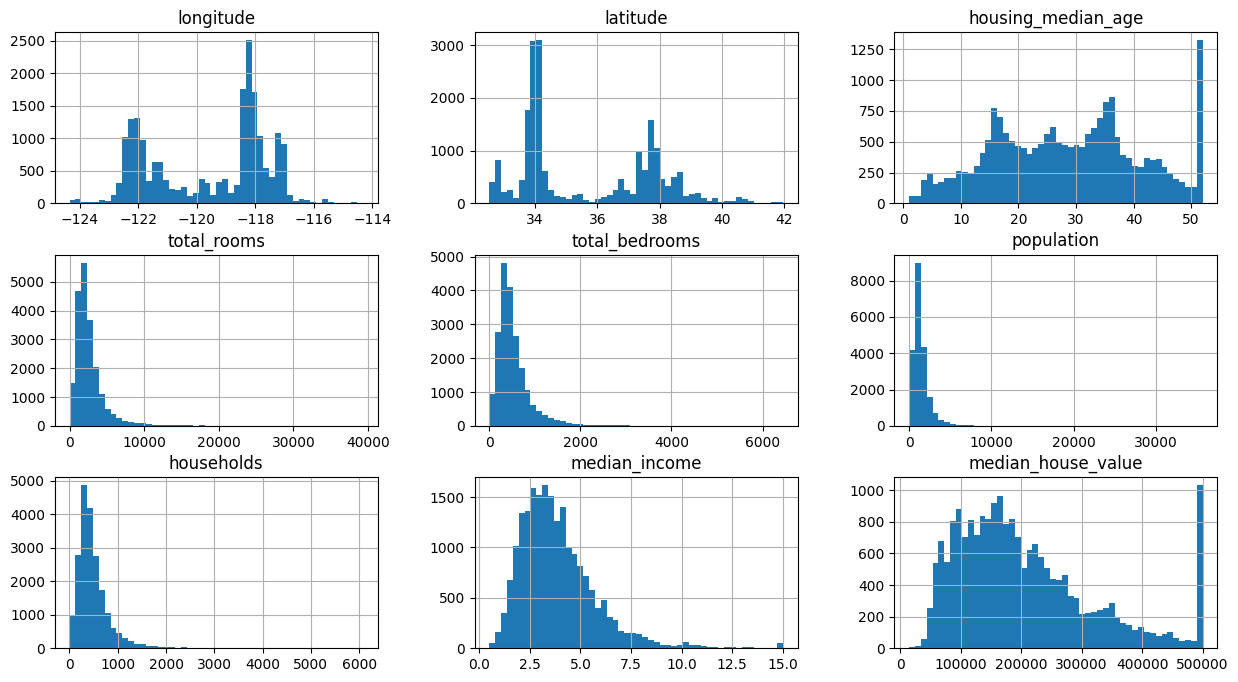

In [7]:
housing.hist(bins=50, figsize=(15,8))

### Some initial observations
* Some attributes are preprocessed:
  * `median_income` has been scaled and capped between 0.4999 and 15.0001
  * `median_hose_value` has been capped to 500000, which explains the spike, and might be a problem because it is the target attribute
  * `housing_median_age` has been capped
* The attributes have different scales
* Many of the histograms are skewed right 

## Train / Test sets

Define a function to shuffle the housing data and split it into two sets according to the specified ratio

In [8]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indeces = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indeces = shuffled_indeces[:test_set_size]
    train_indeces = shuffled_indeces[test_set_size:]
    return data.iloc[train_indeces], data.iloc[test_indeces]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

print(housing.shape)
print(test_set.shape)
print(train_set.shape)
train_set.head()

(20640, 10)
(4128, 10)
(16512, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1933     -118.21     34.56                12.0       2472.0           408.0   
8241     -124.19     40.77                30.0       2975.0           634.0   
20418    -119.18     34.24                17.0        629.0           221.0   
4044     -119.37     36.35                20.0       1132.0           177.0   
9897     -118.56     34.25                31.0       1962.0           243.0   

       population  households  median_income  median_house_value  \
1933       1048.0       380.0         4.7097            262100.0   
8241       1367.0       583.0         2.4420             69000.0   
20418       514.0       186.0         3.2847            112500.0   
4044        518.0       178.0         5.3767            231300.0   
9897        697.0       242.0         8.5650            500001.0   

      ocean_proximity  
1933           INLAND  
8241       NEAR OCEAN  
20418      NEAR OCEAN  
4044           INLAND  
9897        <1H OCEAN

The downside of this approach is that it is not deterministic, and the split will change for each execution.

A solution to this problem is to set the randomness seed, so that we get the same results each time:

In [9]:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    
    shuffled_indeces = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indeces = shuffled_indeces[:test_set_size]
    train_indeces = shuffled_indeces[test_set_size:]
    return data.iloc[train_indeces], data.iloc[test_indeces]


In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.22     32.75                34.0       6001.0          1111.0   
8267     -117.03     32.69                10.0        901.0           163.0   
17445    -122.27     37.74                28.0       6909.0          1554.0   
14265    -121.82     37.25                25.0       4021.0           634.0   
2271     -115.98     33.32                 8.0        240.0            46.0   

       population  households  median_income  median_house_value  \
14196      2654.0      1072.0         4.5878            291000.0   
8267        698.0       167.0         4.6648            156100.0   
17445      2974.0      1484.0         3.6875            353900.0   
14265      2178.0       650.0         5.1663            241200.0   
2271         63.0        24.0         1.4688             53800.0   

      ocean_proximity  
14196      NEAR OCEAN  
8267       NEAR OCEAN  
17445        NEAR BAY  
14265       <1H OCEAN  
2271           INLAND

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.22     32.75                34.0       6001.0          1111.0   
8267     -117.03     32.69                10.0        901.0           163.0   
17445    -122.27     37.74                28.0       6909.0          1554.0   
14265    -121.82     37.25                25.0       4021.0           634.0   
2271     -115.98     33.32                 8.0        240.0            46.0   

       population  households  median_income  median_house_value  \
14196      2654.0      1072.0         4.5878            291000.0   
8267        698.0       167.0         4.6648            156100.0   
17445      2974.0      1484.0         3.6875            353900.0   
14265      2178.0       650.0         5.1663            241200.0   
2271         63.0        24.0         1.4688             53800.0   

      ocean_proximity  
14196      NEAR OCEAN  
8267       NEAR OCEAN  
17445        NEAR BAY  
14265       <1H OCEAN  
2271           INLAND

Now the splits are deterministic.

However, there's another issue with this approach to splitting data. If the data gets updated by adding new samples to the dataset, our inputs will again be shuffled in a different way, so the train and test sets items will not persist. It would be better if only the new samples in the dataset get shuffled and added to our current train and test sets.

To achieve this, we could assing an id to each sample, and use this id to generate a random value to be used to split the data. A good candidate for id would be `longitude + latitude` since the combination of those fields will not change if the dataset is updated, and the value should not be repeated.

In [12]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    is_in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))

    return data[~is_in_test_set], data[is_in_test_set]

In [13]:
housing['id'] = housing['longitude'] * 100000 + housing['latitude']

train_set, test_set = split_data_with_id_hash(housing, 0.2, 'id')
print(housing.shape)
print(test_set.shape)
print(train_set.shape)

train_set.head()

(20640, 11)
(3967, 11)
(16673, 11)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -122.23     37.88                41.0        880.0           129.0   
1     -122.22     37.86                21.0       7099.0          1106.0   
2     -122.24     37.85                52.0       1467.0           190.0   
8     -122.26     37.84                42.0       2555.0           665.0   
10    -122.26     37.85                52.0       2202.0           434.0   

    population  households  median_income  median_house_value ocean_proximity  \
0        322.0       126.0         8.3252            452600.0        NEAR BAY   
1       2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2        496.0       177.0         7.2574            352100.0        NEAR BAY   
8       1206.0       595.0         2.0804            226700.0        NEAR BAY   
10       910.0       402.0         3.2031            281500.0        NEAR BAY   

             id  
0  -12222962.12  
1  -12221962.14  
2  -12223962.15  
8  -12225962.16  
10 -12225962.15

Now any new sample will be included in the test or training set deterministically and according to the specified ratio for test data.

Something to note is that the split has not been 80% - 20% exactly, that happens because we are relying on the probability of the generated crc32 code to be less than the value in the lower 20% of all possible values. The more samples we have the more we will approach to the specified ratio.

### Avoiding sampling bias

We are told that the `median_income` attribute is very important to predict the `median_housing_price`, so we want to ensure that the test set is representative of the different values that `median_income` can take. Since the attribute is continuous, we will have to make categories out of it.

Lets look at the values again:

<Axes: >

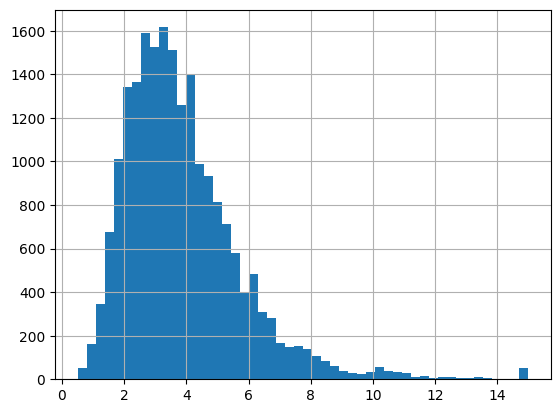

In [14]:
housing['median_income'].hist(bins=50)

Most median income values are between 1.5 and 6. We will divide the values into categories to ensure that each category is large enough to be representative

In [15]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

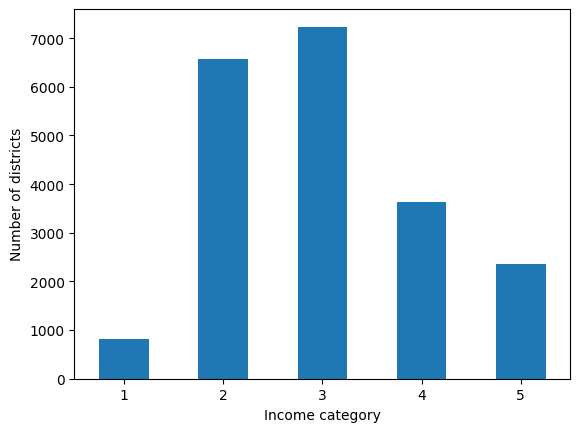

In [16]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel('Income category')
plt.ylabel('Number of districts')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

Comparison of the % of samples in each income category between the whole dataset, the stratified split and the non stratified split:

In [25]:
housing['income_cat'].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [21]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [24]:
non_strat_train_set, non_strat_test_set = train_test_split(housing, test_size=0.2, random_state=42)
non_strat_test_set['income_cat'].value_counts() / len(non_strat_test_set)

income_cat
3    0.345203
2    0.307413
4    0.184109
5    0.120882
1    0.042393
Name: count, dtype: float64

The percentages in the whole data and the stratified test set are almost the same

Delete the `income_cat` attribute, as it will no longer be used

In [26]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)